In [1]:
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GroupKFold, KFold
import gc
import json
pd.set_option('display.max_columns', 1000)
from sklearn import metrics


from bayes_opt import BayesianOptimization


/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [1]:
##### event_id - ランダムに生成されたイベント固有の値であり、specsとマッピングしている。
##### game_session - ゲームかビデオプレイについてのグルーピングされた固有の値
##### timestamp - クライアントが生成された時間
##### event_data - 準構造化されたイベントパラメータを含むJSON
#####              event_count, event_code, and game_timeをデフォルトで含む、またはeventtypeで決められる。
##### installation_id - ゲームセッションでグルーピングされた、
#####               インストールされた単一のアプリケーションの中のランダムな固有の値
##### event_count - eventdataから取得される1つのゲームセッションに対するイベント内の増加値
##### event_code - ゲームごとのイベントクラスの固有の値だが、ゲーム別で重複するかもしれない。2000は必ずゲームスタート。
##### game_time - Time in milliseconds since the start of the game session. Extracted from event_data.
##### title - ゲームまたはビデオのタイトル
##### type - ゲームまたはビデオのタイプ、'Game', 'Assessment', 'Activity', 'Clip'.
##### world - ビデオまたはゲームの属するセクション メディアのゴールを特定するのに役立つ。
#####       'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 
#####       'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

# Objective

* Try adversarial validation
* All comments are appreciated

In [2]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('./input/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))
    print('Reading test.csv file....')
    test = pd.read_csv('./input/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))
    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('./input/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))
    print('Reading specs.csv file....')
    specs = pd.read_csv('./input/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))
    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('./input/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [3]:
def encode_title(train, test, train_labels):
    #イベントコードはゲーム別のため、ゲームタイトルとイベントコードを結合して保持する。
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))

    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [4]:
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    last_game_time_title = {'lgt_' + title: 0 for title in assess_titles}
    ac_game_time_title = {'agt_' + title: 0 for title in assess_titles}
    ac_true_attempts_title = {'ata_' + title: 0 for title in assess_titles}
    ac_false_attempts_title = {'afa_' + title: 0 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(title_count.copy())
            features.update(event_id_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_game_time_title.copy())
            features.update(ac_game_time_title.copy())
            features.update(ac_true_attempts_title.copy())
            features.update(ac_false_attempts_title.copy())
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            
            # ----------------------------------------------
            ac_true_attempts_title['ata_' + session_title_text] += true_attempts
            ac_false_attempts_title['afa_' + session_title_text] += false_attempts
            
            
            last_game_time_title['lgt_' + session_title_text] = session['game_time'].iloc[-1]
            ac_game_time_title['agt_' + session_title_text] += session['game_time'].iloc[-1]
            # ----------------------------------------------
            
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [5]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [6]:
# function that creates more features
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']]
    return reduce_train, reduce_test, features

In [7]:
# thanks to Andrew
def get_label(vector):
    vector[vector <= 1.12232214] = 0
    vector[np.where(np.logical_and(vector > 1.12232214, vector <= 1.73925866))] = 1
    vector[np.where(np.logical_and(vector > 1.73925866, vector <= 2.22506454))] = 2
    vector[vector > 2.22506454] = 3
    return vector
    
def cohen_kappa(y_pred, y):
    y = y.get_label().astype("int")
    y_pred = get_label(y_pred)
    loss = cohen_kappa_score(y, y_pred, weights = 'quadratic')
    return "cohen kappa score", loss, True

In [8]:
def run_feature_selection(reduce_train, reduce_test, features, new_features, categoricals):
    
    # define lgbm hyperparammeters
    params = {
            'learning_rate': 0.1,
            'feature_fraction': 0.75,
            'subsample': 0.75,
            'n_jobs': -1,
            'seed': 50,
            'max_depth': 10
        }
    
    # define a GroupKFold strategy because we are predicting unknown installation_ids
    kf = GroupKFold(n_splits = 5)
    target = 'accuracy_group'
    oof_pred = np.zeros(len(reduce_train))
    
    # train a baseline model and record the cohen cappa score as our best score
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, groups = reduce_train['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[features].iloc[tr_ind], reduce_train[features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature = categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature = categoricals)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 100, 
                         valid_sets = [train_set, val_set], verbose_eval = 500, feval = cohen_kappa)
        
        oof_pred[val_ind] = model.predict(x_val)
        
    # calculate loss
    loss_score = cohen_kappa_score(reduce_train[target], get_label(oof_pred), weights = 'quadratic')
    score = loss_score
        
    usefull_features = []
    for i in new_features:
        print('Our best cohen kappa score is :', score)
        oof_pred = np.zeros(len(reduce_train))
        print('Evaluating feature :', i)
        best_features = features + usefull_features + [i]
        print('Training with {} features'.format(len(best_features)))
        for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, groups = reduce_train['installation_id'])):
            print('Fold {}'.format(fold + 1))
            x_train, x_val = reduce_train[best_features].iloc[tr_ind], reduce_train[best_features].iloc[val_ind]
            y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
            train_set = lgb.Dataset(x_train, y_train, categorical_feature = categoricals)
            val_set = lgb.Dataset(x_val, y_val, categorical_feature = categoricals)

            model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 100, 
                                valid_sets=[train_set, val_set], verbose_eval = 500, feval = cohen_kappa)
            oof_pred[val_ind] = model.predict(x_val)
              
        loss_score = cohen_kappa_score(reduce_train[target], get_label(oof_pred), weights = 'quadratic')
        print('Our new cohen kappa score is : {}'.format(loss_score))
        
        if loss_score > score:
            print('Feature {} is usefull, adding feature to usefull feature list'.format(i))
            usefull_features.append(i)
            score = loss_score
        else:
            print('Feature {} is useless'.format(i))
        gc.collect()
        print('-'*50)
              
    usefull_features = features + usefull_features
    print('The best feature are: ', usefull_features)
    print('Our best cohen kappa score :', score)
              
    return usefull_features

In [9]:
def run_lgb(reduce_trian, reduce_test, usefull_features, params):
    
    # define a GroupKFold strategy because we are predicting unknown installation_ids
    kf = GroupKFold(n_splits = 5)
    target = 'accuracy_group'
    oof_pred = np.zeros(len(reduce_train))
    y_pred = np.zeros(len(reduce_test))
    
    # train a baseline model and record the cohen cappa score as our best score
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, groups = reduce_train['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 100, 
                         valid_sets = [train_set, val_set], verbose_eval = 100, feval = cohen_kappa)
        
        oof_pred[val_ind] = model.predict(x_val)
        
        y_pred += model.predict(reduce_test[usefull_features]) / kf.n_splits
        
    # calculate loss
    loss_score = cohen_kappa_score(reduce_train[target], get_label(oof_pred), weights = 'quadratic')
    print('Our oof cohen kappa score is :', loss_score)
    return y_pred


def run_lgb_bayesian(num_leaves, max_depth, lambda_l1, lambda_l2, bagging_fraction, bagging_freq, colsample_bytree, learning_rate):
    
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 42,
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),
        'colsample_bytree': colsample_bytree,
        'verbose': 0
    }
    
    # define a GroupKFold strategy because we are predicting unknown installation_ids
    kf = GroupKFold(n_splits = 5)
    target = 'accuracy_group'
    oof_pred = np.zeros(len(reduce_train))
    y_pred = np.zeros(len(reduce_test))
    
    # train a baseline model and record the cohen cappa score as our best score
    for fold, (tr_ind, val_ind) in enumerate(kf.split(reduce_train, groups = reduce_train['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = reduce_train[usefull_features].iloc[tr_ind], reduce_train[usefull_features].iloc[val_ind]
        y_train, y_val = reduce_train[target][tr_ind], reduce_train[target][val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 100, 
                         valid_sets = [train_set, val_set], verbose_eval = False, feval = cohen_kappa)
        
        oof_pred[val_ind] = model.predict(x_val)
        
        y_pred += model.predict(reduce_test[usefull_features]) / kf.n_splits
        
    # calculate loss
    loss_score = cohen_kappa_score(reduce_train[target], get_label(oof_pred), weights = 'quadratic')
    return loss_score


def predict(sample_submission, y_pred):
    sample_submission['accuracy_group'] = get_label(y_pred)
    sample_submission['accuracy_group'] = sample_submission['accuracy_group'].astype(int)
    sample_submission.to_csv('submission.csv', index = False)
    print(sample_submission['accuracy_group'].value_counts(normalize = True))

In [10]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)
# call feature engineering function
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


In [11]:
# old features, were extracted with the feature selection function
features = ['Assessment', 'Game', 'acc_Cauldron Filler (Assessment)', 'acc_Chest Sorter (Assessment)', 'acc_Mushroom Sorter (Assessment)', 'acc_Cart Balancer (Assessment)', 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 
            2075, 2080, 2081, 2083, 4010, 3120, 3121, 4020, 4021, 4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 2040, 4090, 4220, 4095, 
            'Dino Drink', 'Egg Dropper (Activity)', 'Tree Top City - Level 3', 'Leaf Leader', 'Dino Dive', "Pirate's Tale", 'Sandcastle Builder (Activity)', 'Bottle Filler (Activity)', 'Bird Measurer (Assessment)', 
            'Chicken Balancer (Activity)', 'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'All Star Sorting', 'Slop Problem', 'Scrub-A-Dub', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Treasure Map', 
            'Magma Peak - Level 1', 'Watering Hole (Activity)', 'Bubble Bath', 'Crystal Caves - Level 3', 'Rulers', 'Bug Measurer (Activity)', 'Lifting Heavy Things', 'Tree Top City - Level 2', 'Pan Balance', 
            'Magma Peak - Level 2', 'Chow Time', 'Tree Top City - Level 1', 'Costume Box', 'Crystal Caves - Level 2', 'Crystals Rule', 'Happy Camel', 'Welcome to Lost Lagoon!', 'Crystal Caves - Level 1', 
            'Air Show', '12 Monkeys', 'Balancing Act', 'Fireworks (Activity)', 'Flower Waterer (Activity)', 'lgt_Cauldron Filler (Assessment)', 'lgt_Chest Sorter (Assessment)', 'lgt_Mushroom Sorter (Assessment)', 
            'lgt_Cart Balancer (Assessment)', 'lgt_Bird Measurer (Assessment)', 'agt_Cauldron Filler (Assessment)', 'agt_Chest Sorter (Assessment)', 'agt_Mushroom Sorter (Assessment)', 'agt_Cart Balancer (Assessment)', 
            'agt_Bird Measurer (Assessment)', 'ata_Cauldron Filler (Assessment)', 'ata_Chest Sorter (Assessment)', 'ata_Mushroom Sorter (Assessment)', 'ata_Cart Balancer (Assessment)', 'ata_Bird Measurer (Assessment)', 
            'afa_Cauldron Filler (Assessment)', 'afa_Chest Sorter (Assessment)', 'afa_Mushroom Sorter (Assessment)', 'afa_Cart Balancer (Assessment)', 'afa_Bird Measurer (Assessment)', 'session_title', 
            'accumulated_correct_attempts', 'accumulated_uncorrect_attempts', 'duration_mean', 'accumulated_accuracy', 0, 1, 2, 3, 'accumulated_accuracy_group', 'accumulated_actions', 'installation_session_count', 
            'installation_duration_mean', 'installation_title_nunique', 'installation_event_code_count_mean', 'sum_event_code_count']
event_id_features = list(reduce_train.columns[95:479])
title_event_code_cross = list(reduce_train.columns[479:882])
# get categories with more than 50 unique values
id_over = list(reduce_train[event_id_features].nunique()[reduce_train[event_id_features].nunique()>50].index)
title_event_over = list(reduce_train[title_event_code_cross].nunique()[reduce_train[title_event_code_cross].nunique()>50].index)
print('We are using {} features from event_id counts'.format(len(id_over)))
print('We are using {} features from title_event_cross counts'.format(len(title_event_over)))
features = features + id_over + title_event_over

We are using 219 features from event_id counts
We are using 226 features from title_event_cross counts


Let's make another filter and use adversarial validation to eliminate features. The main idea of adversarial validations is to train a ml model and check if the model can figure out if the data is from the train or test set.

If it can, this means that the data comes from another distribution and that's not a good thing.

In [12]:
def run_av(reduce_train, reduce_test, usefull_features):
    
    tr_data = reduce_train.copy()
    tst_data = reduce_test.copy()
    tr_data['target'] = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data[[col for col in tr_data.columns if col not in ['accuracy_group']]], tst_data[[col for col in tst_data.columns if col not in ['accuracy_group']]]], axis = 0)
    
    # undersample majority class
    positive = av_data[av_data['target']==1]
    negative = av_data[av_data['target']==0]
    negative = negative.sample(int(negative.shape[0] * 0.5), random_state = 42)
    av_data = pd.concat([negative, positive], axis = 0)
    
    # reset index and shuffle
    av_data.reset_index(drop = True)
    from sklearn.utils import shuffle
    av_data = shuffle(av_data)
        
    params = {
            'learning_rate': 0.05, 
            'n_jobs': -1,
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'is_unbalance': True,
            'metric': 'auc',
        }
    
    # define a KFold strategy
    kf = GroupKFold(n_splits = 5)
    target = 'target'
    oof_pred = np.zeros(len(av_data))
    important_features = pd.DataFrame()
    fold_auc = []
    
    
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, groups = av_data['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[usefull_features].iloc[tr_ind], av_data[usefull_features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                         valid_sets = [train_set, val_set], verbose_eval = 100)
        
        fold_importance = pd.DataFrame()
        fold_importance['features'] = usefull_features
        fold_importance['importance'] = model.feature_importance()
        important_features = pd.concat([important_features, fold_importance], axis = 0)
        
        oof_pred[val_ind] = model.predict(x_val)
        fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
    print('Our mean train roc auc score is :', np.mean(fold_auc))
    print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
    return important_features

important_features = run_av(reduce_train, reduce_test, features)

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.997242	valid_1's auc: 0.98679
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.994585	valid_1's auc: 0.987606
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.997092	valid_1's auc: 0.988784
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.996924	valid_1's auc: 0.985289
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.996475	valid_1's auc: 0.986765
Our mean train roc auc score is : 0.996463562912313
Our oof roc auc score is : 0.9764700395703788


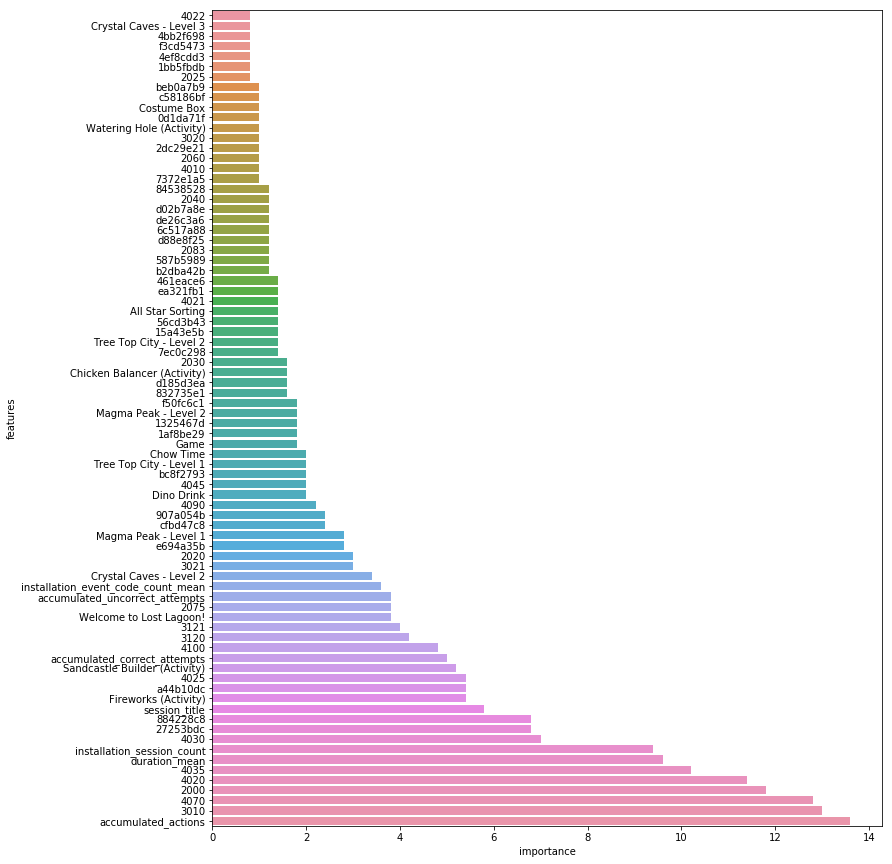

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12,15))
important_features = important_features.groupby('features')['importance'].mean().reset_index().sort_values('importance')
sns.barplot(important_features['importance'][-80:], important_features['features'][-80:])

Let's drop the features that are usefull for detecting the target variable and run adversarial validatation again. I believe that installation features can be a reason.

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.860284	valid_1's auc: 0.681904
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's auc: 0.812864	valid_1's auc: 0.698596
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.81666	valid_1's auc: 0.698778
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's auc: 0.926204	valid_1's auc: 0.693795
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.852155	valid_1's auc: 0.678648
Our mean train roc auc score is : 0.8536332922740357
Our oof roc auc score is : 0.6428789711701526


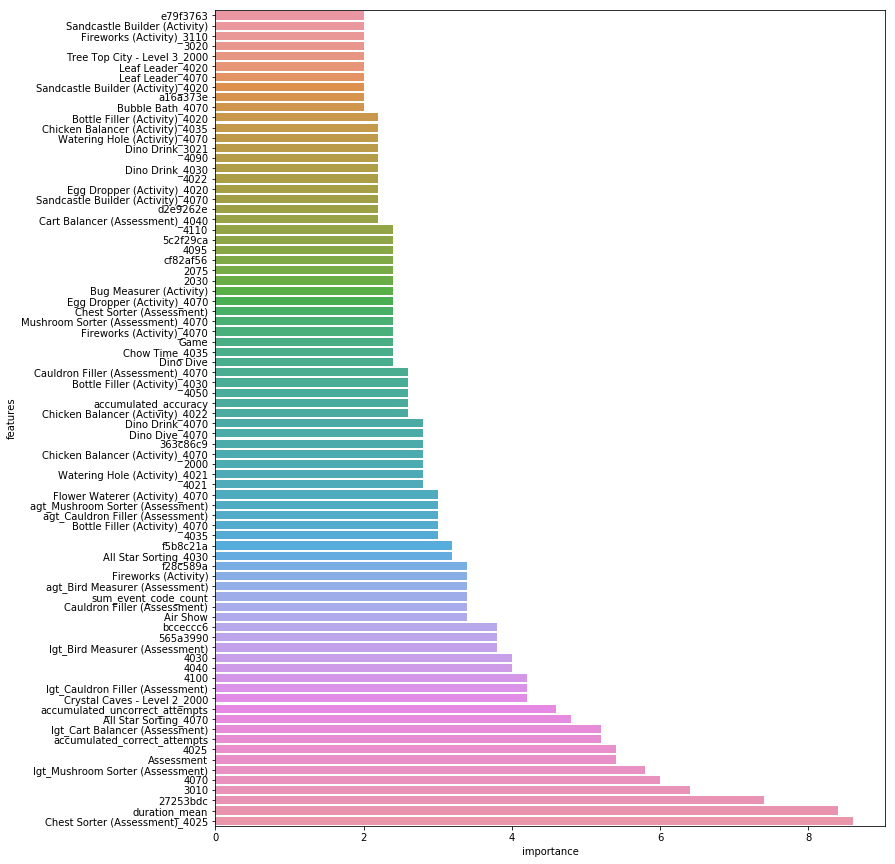

In [14]:
av_features = [col for col in list(important_features['features']) if col not in ['installation_session_count', 'installation_duration_mean', 'installation_title_nunique', 'installation_event_code_count_mean']]
important_features = run_av(reduce_train, reduce_test, av_features)
plt.figure(figsize = (12,15))
important_features = important_features.groupby('features')['importance'].mean().reset_index().sort_values('importance')
sns.barplot(important_features['importance'][-80:], important_features['features'][-80:])

Much better, our model can still detect train and test. On the other hand check training roc_auc and val roc_auc (the model is overfitting big time).

Nevertheless want to try and check the results.

Let's build a function that drop one feature and check if the oof validation falls, if it falls we drop it.

In [15]:
def run_av_check(reduce_train, reduce_test, usefull_features):
    
    tr_data = reduce_train.copy()
    tst_data = reduce_test.copy()
    tr_data['target'] = 0 
    tst_data['target'] = 1
    av_data = pd.concat([tr_data[[col for col in tr_data.columns if col not in ['accuracy_group']]], tst_data[[col for col in tst_data.columns if col not in ['accuracy_group']]]], axis = 0)
    
     # undersample majority class
    positive = av_data[av_data['target']==1]
    negative = av_data[av_data['target']==0]
    negative = negative.sample(int(negative.shape[0] * 0.5), random_state = 42)
    av_data = pd.concat([negative, positive], axis = 0)
    
    # reset index and shuffle
    av_data.reset_index(drop = True)
    from sklearn.utils import shuffle
    av_data = shuffle(av_data)
        
        
    params = {
            'learning_rate': 0.05, 
            'n_jobs': -1,
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'is_unbalance': True,
            'metric': 'auc'
        }
    
    # define a KFold strategy
    kf = GroupKFold(n_splits = 5)
    target = 'target'
    
    oof_pred = np.zeros(len(av_data))
    for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, groups = av_data['installation_id'])):
        print('Fold {}'.format(fold + 1))
        x_train, x_val = av_data[usefull_features].iloc[tr_ind], av_data[usefull_features].iloc[val_ind]
        y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                         valid_sets = [train_set, val_set], verbose_eval = 100)
    
        
        oof_pred[val_ind] = model.predict(x_val)
    
    score = metrics.roc_auc_score(av_data[target], oof_pred)
    
    iter_features = usefull_features[::-1].copy()
    drop_features = []
    for i in iter_features:
        oof_pred = np.zeros(len(av_data))
        check_features = [col for col in iter_features if col not in drop_features + [i]]
        print('Checking feature:', i)
        for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, groups = av_data['installation_id'])):
            x_train, x_val = av_data[check_features].iloc[tr_ind], av_data[check_features].iloc[val_ind]
            y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
            train_set = lgb.Dataset(x_train, y_train)
            val_set = lgb.Dataset(x_val, y_val)

            model = lgb.train(params, train_set, num_boost_round = 100000, early_stopping_rounds = 20, 
                             valid_sets = [train_set, val_set], verbose_eval = False)


            oof_pred[val_ind] = model.predict(x_val)
            
        rauc = metrics.roc_auc_score(av_data[target], oof_pred)
            
        if rauc < score:
            print('Dropping feature: ', i)
            score = rauc
            drop_features.append(i)
        else:
            print('Feature {} is usefull'.format(i))
            
        print('Out best roc auc score is :', score)
            
        print('-'*50)
        print('_'*50)
            
    usefull_features = [col for col in usefull_features if col not in drop_features]
    return usefull_features

usefull_features = run_av_check(reduce_train, reduce_test, list(important_features['features']))

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	training's auc: 0.85173	valid_1's auc: 0.681869
Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.797859	valid_1's auc: 0.699932
Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.81666	valid_1's auc: 0.698778
Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's auc: 0.926204	valid_1's auc: 0.693853
Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.852155	valid_1's auc: 0.678648
Checking feature: Chest Sorter (Assessment)_4025
Feature Chest Sorter (Assessment)_4025 is usefull
Out best roc auc score is : 0.6383651215375918
--------------------------------------------------
______________________

In [16]:
# run bayezian optimization with optimal features

bounds_lgb = {
    'num_leaves': (20, 300),
    'max_depth': (8, 12),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'bagging_fraction': (0.4, 1),
    'bagging_freq': (1, 10),
    'colsample_bytree': (0.4, 1),
    'learning_rate': (0.025, 0.1)
}

lgb_bo = BayesianOptimization(run_lgb_bayesian, bounds_lgb, random_state = 236)
lgb_bo.maximize(init_points = 20, n_iter = 20, acq = 'ucb', xi = 0.0, alpha = 1e-6)

params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'eval_metric': 'cappa',
    'n_jobs': -1,
    'seed': 42,
    'num_leavs': lgb_bo.max['params']['num_leaves'],
    'learning_rate': lgb_bo.max['params']['learning_rate'],
    'max_depth': int(lgb_bo.max['params']['max_depth']),
    'lambda_l1': lgb_bo.max['params']['lambda_l1'],
    'lambda_l2': lgb_bo.max['params']['lambda_l2'],
    'bagging_fraction': lgb_bo.max['params']['bagging_fraction'],
    'bagging_freq': int(lgb_bo.max['params']['bagging_freq']),
    'colsample_bytree': lgb_bo.max['params']['colsample_bytree']}

|   iter    |  target   | baggin... | baggin... | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------------------------------------------
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
|  1        |  0.5676   |  0.4467   |  8.296    |  0.4692   |  4.144    |  1.756    |  0.08898  |  11.88    |  219.8    |
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
|  2        |  0.5865   |  0.8278   |  7.868    |  0.789    |  4.577    |  1.547    |  0.08672  |  8.531    |  67.1     |
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
|  3        |  0.5778   |  0.5908   |  1.023    |  0.4542   |  0.4685   |  3.663    |  0.0469   |  10.78    |  280.6    |
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
|  4        |  0.5733   |  0.5296   |  5.274    |  0.7894   |  1.487    |  0.6649   |  0.09643  |  9.712    |  139.2    |
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
|  5        |  0.569    |  0.6158   |  5.52     |  0.51     |  0.8052   |  4.047    |  0.0964

In [17]:
# train with usefull features
y_pred = run_lgb(reduce_train, reduce_test, usefull_features, params)
# call predict function
predict(sample_submission, y_pred)

Fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.87498	training's cohen kappa score: 0.70672	valid_1's rmse: 0.978332	valid_1's cohen kappa score: 0.607528
Early stopping, best iteration is:
[98]	training's rmse: 0.876697	training's cohen kappa score: 0.705336	valid_1's rmse: 0.977914	valid_1's cohen kappa score: 0.605816
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.875631	training's cohen kappa score: 0.706072	valid_1's rmse: 0.992392	valid_1's cohen kappa score: 0.596119
[200]	training's rmse: 0.803497	training's cohen kappa score: 0.764402	valid_1's rmse: 0.993468	valid_1's cohen kappa score: 0.601109
Early stopping, best iteration is:
[125]	training's rmse: 0.854353	training's cohen kappa score: 0.720659	valid_1's rmse: 0.991839	valid_1's cohen kappa score: 0.60156
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.874863	training's cohen kappa sc